<h1>Chord Estimation</h1>
<br>
In this Notebook we are going to explore a different representation for the chords, similarly as used in a paper from mirex
<br>

In [1]:
import sys
# do this only once
sys.path.append('./src/audio_processing/')
sys.path.append('./src/data_processing/')
sys.path.append('./src/chord_parser/')
sys.path.append('./src/metrics/')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#python input/output and regex
import re
import os
from pathlib import Path

#chord info
import pychord as pc

#signal processing libraries
from scipy.io import wavfile
from scipy import signal

#sklearn for normalization
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#tensorflow
import tensorflow as tf
from tensorflow import keras

#librosa
import librosa
import librosa.display

#mirex
import mir_eval

#import custom modules
import filters
import spectrograms
import audiofiles
from annotation_processing import chords_to_onehot

## CQT
- number of bins = 192
- bins per octave = 24
- sample rate = 22050 Hz
- min frequency = C1 (~31Hz)
- hop_length = 2048

In [3]:
nbins=192
bins_per_octave=24
hop_length=2048
audiofiles_path = 'Audiofiles/The Beatles/original'
input_features = nbins
Artist = 'The Beatles'

Timeseries = {'The Beatles': {}}
Timestamps = {'The Beatles': {}}

In [4]:
## cqt on isophonics
for filename in Path(audiofiles_path).glob('**/*.wav'):

    path, track = os.path.split(filename)
    path, album = os.path.split(path)

    track_no = re.search('([0-9].).', track).group(1)

    # read wav and create spectrogram
    track, sample_rate = librosa.load(filename, sr = 22050)
    track_time = librosa.get_duration(y=track, sr=sample_rate)
#     n_fft = int(track_time // (hop_length / sample_rate))
    
    spectrogram = librosa.cqt(track, sr=sample_rate, n_bins=nbins, bins_per_octave=bins_per_octave, hop_length=hop_length)

    frames = list(range(0, spectrogram.shape[1]))
    times = librosa.frames_to_time(frames, sr=sample_rate, hop_length=hop_length)

    if album not in Timeseries[Artist]:
        Timeseries[Artist][album] = {}
        Timestamps[Artist][album] = {}

    Timeseries[Artist][album][track_no] = librosa.amplitude_to_db(abs(spectrogram), ref=np.max).T
    Timestamps[Artist][album][track_no] = times

In [6]:
# Scale Spectrogram Data
for album in Timeseries[Artist].keys():
    for track_no in Timeseries[Artist][album]:
        Timeseries[Artist][album][track_no] += 80

Only if in possesion of billboard **GLOBAL z-normalization**

In [36]:
## OPTIONAL !!

global_Scaler = StandardScaler()

for artist in Timeseries.keys():
    for album in Timeseries[artist].keys():
        for track_no, track_data in Timeseries[artist][album].items():
            global_Scaler.fit(track_data)
            
for track_no, track_data in Timeseries_Billboard.items():
    global_Scaler.fit(track_data)
            
for artist in Timeseries.keys():
    for album in Timeseries[artist].keys():
        for track_no, track_data in Timeseries[artist][album].items():
            Timeseries[artist][album][track_no] = global_Scaler.transform(track_data)
            
for track_no, track_data in Timeseries_Billboard.items():
    Timeseries_Billboard[track_no] = global_Scaler.transform(track_data)

## Annotations

#### Isophonics

In [5]:
### get all chordlab files
Chordlab = {'The Beatles': {}}
for filename in Path('Big-Dataset/The Beatles').glob('**/scratch/**/*.lab'):
    
    path, track = os.path.split(filename)
    path, album = os.path.split(path)
    track_no = re.search('([0-9].)_-_',track).group(1)
    
    if (album not in Chordlab['The Beatles']): 
        Chordlab['The Beatles'][album] = {}
        
    Chordlab['The Beatles'][album][track_no] = pd.read_csv(filename, names=['Starts', 'Ends', 'Chord'], sep=' ', header=None)

<br>

## Data Augmentation

### Audio

In [7]:
## cqt on isophonics
for nshift, shift in [(1, 'up1'), (-1, 'down1'), (2, 'up2'), (-2, 'down2'),(3, 'up3'), (-3, 'down3'), (4, 'up4'), (-4, 'down4'), (5, 'up5'), (-5, 'down5'), (6, 'up6')]:
    for filename in Path(audiofiles_path).glob('**/*.wav'):

        path, track = os.path.split(filename)
        path, album = os.path.split(path)

        track_no = re.search('([0-9].).', track).group(1)

        # read wav
        track, sample_rate = librosa.load(filename, sr = 22050)
        # create gaussian noise
        mean = np.mean(track)
        var = np.var(track)
        noise = np.random.normal(mean, var, track.shape)
        # add noise
        track += noise
        # pitch shift
        y_shifted = librosa.effects.pitch_shift(track, sample_rate, n_steps=nshift)
        # create cqt
        spectrogram = librosa.cqt(y_shifted, sr=sample_rate, n_bins=nbins, bins_per_octave=bins_per_octave, hop_length=hop_length)
        # timesteps
        frames = list(range(0, spectrogram.shape[1]))
        times = librosa.frames_to_time(frames, sr=sample_rate, hop_length=hop_length)
        
        # output
        new_album = album + '_' + shift
        if new_album not in Timeseries['The Beatles']:
            Timeseries['The Beatles'][new_album] = {}
            Timestamps['The Beatles'][new_album] = {}

        new_track = track_no + '_' + shift
        Timeseries['The Beatles'][new_album][new_track] = librosa.amplitude_to_db(abs(spectrogram), ref=np.max).T
        Timestamps['The Beatles'][new_album][new_track] = times

In [8]:
# Scale Spectrogram Data
for album in Timeseries[Artist].keys():
    for track_no in Timeseries[Artist][album]:
        if album.find('_down') != -1 or album.find('_up') != -1:
            Timeseries[Artist][album][track_no] += 80

### Annotations

In [9]:
ChordLib = {'C' : 0, 'C#': 1, 'Db' : 1, 'D' : 2, 'D#' : 3, 'Eb' : 3, 'E' : 4, 'Fb' : 4,
            'F' : 5, 'F#' : 6, 'Gb' : 6, 'G' : 7, 'G#' : 8, 'Ab' : 8, 'A' : 9, 'A#' : 10,
            'Bb' : 10, 'B' : 11, 'Cb' : 11, 'N' : 12, 'X' : 13}
Harmonic_Equivalents = {'A#' : 'Bb', 'C#' : 'Db', 'D#' : 'Eb', 'F#' : 'Gb', 'G#' : 'Ab'}
Semitone_List = ['C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'G#', 'A', 'Bb', 'B']

In [10]:
for filename in Path('Big-Dataset/The Beatles').glob('**/scratch/**/*.lab'):
    
    path, track = os.path.split(filename)
    path, album = os.path.split(path)
    track_no = re.search('([0-9].)_-_',track).group(1)
    
    for pitch_shift, nshift in [('up1', 1), ('down1', 1), ('up2', 2), ('down2', 2),('up3', 3), ('down3', 3), ('up4', 4), ('down4', 4), ('up5', 5), ('down5', 5), ('up6', 6)]:
        new_album = album + '_' + pitch_shift
        new_track = track_no + '_' + pitch_shift
        
        if (new_album not in Chordlab['The Beatles']): 
            Chordlab['The Beatles'][new_album] = {}
        
        if pitch_shift.find('down') != -1:
            chord_list = []
            for _, starts, ends, chord in Chordlab['The Beatles'][album][track_no].itertuples():
                rest = ''
                if chord != 'N':
                    if chord.find(':') != -1:
                        chord, rest = chord.split(':')
                        rest = ':' + rest
                    if chord.find('/') != -1:
                        chord, rest = chord.split('/')
                        rest = '/' + rest
                    chord_list.append([starts, ends, Semitone_List[ChordLib[chord] - nshift] + rest])
                else:
                    chord_list.append([starts, ends, chord])

            df = pd.DataFrame(chord_list, columns = ['Starts', 'Ends', 'Chord'])
            Chordlab[Artist][new_album][new_track] = df
        else:
            chord_list = []
            for _, starts, ends, chord in Chordlab['The Beatles'][album][track_no].itertuples():
                rest = ''
                if chord != 'N':
                    if chord.find(':') != -1:
                        chord, rest = chord.split(':')
                        rest = ':' + rest
                    if chord.find('/') != -1:
                        chord, rest = chord.split('/')
                        rest = '/' + rest
                    chord_list.append([starts, ends, Semitone_List[(ChordLib[chord] + nshift)%12] + rest])
                else:
                    chord_list.append([starts, ends, chord])

            df = pd.DataFrame(chord_list, columns = ['Starts', 'Ends', 'Chord'])
            Chordlab[Artist][new_album][new_track] = df

In [11]:
import pickle

with open('timeseries.pickle', 'wb') as handle:
    pickle.dump(Timeseries, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('timestamps.pickle', 'wb') as handle:
    pickle.dump(Timestamps, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import pickle

with open('timeseries.pickle', 'rb') as handle:
    Timeseries = pickle.load(handle)
    
with open('timestamps.pickle', 'rb') as handle:
    Timestamps = pickle.load(handle)

## Chord Vocab

In [44]:
### Load all chords in a dictionary
Chords = []
Appearances = {}
for album in Chordlab['The Beatles'].keys():
    for track_no in Chordlab['The Beatles'][album].keys():
        for index, row in Chordlab['The Beatles'][album][track_no].iterrows():
            if row['Chord'] not in Chords: 
                Chords.append(row['Chord'])
                Appearances[row['Chord']] = 0
            else: 
                Appearances[row['Chord']] += 1
            
### How many chords do we have in our dataset?
print ("Unique Chords in our Dataset: ",len(Chords))

Unique Chords in our Dataset:  1672


## Chord Analysis

In [13]:
Analytic_Library = {}
Simple_Library = {}
Mode_Library = {}
Extra_Chords_Appearances = 0
Total_Chords_Appearances = 0
for album in Chordlab['The Beatles'].keys():
    for track_no in Chordlab['The Beatles'][album].keys():
        for index, row in Chordlab['The Beatles'][album][track_no].iterrows():
            Total_Chords_Appearances += 1
            # full chord
            if row['Chord'] in Simple_Library.keys():
                Simple_Library[row['Chord']] += 1
            else:
                Simple_Library[row['Chord']] = 1
            # break chord
            root, quality, extra, bass = mir_eval.chord.split(row['Chord'])
            # total count of root
            if root not in Analytic_Library.keys():
                Analytic_Library[root] = {}
                Analytic_Library[root]['Total'] = 0
            Analytic_Library[root]['Total'] += 1
            # quality
            if quality == '': quality = 'maj'
            if quality not in Mode_Library.keys():
                Mode_Library[quality] = 1
            else:
                Mode_Library[quality] += 1
                
            if quality in Analytic_Library[root].keys():
                Analytic_Library[root][quality] += 1
            else:
                Analytic_Library[root][quality] = 1
            # extra
            if len(extra) > 0:
                Extra_Chords_Appearances += 1

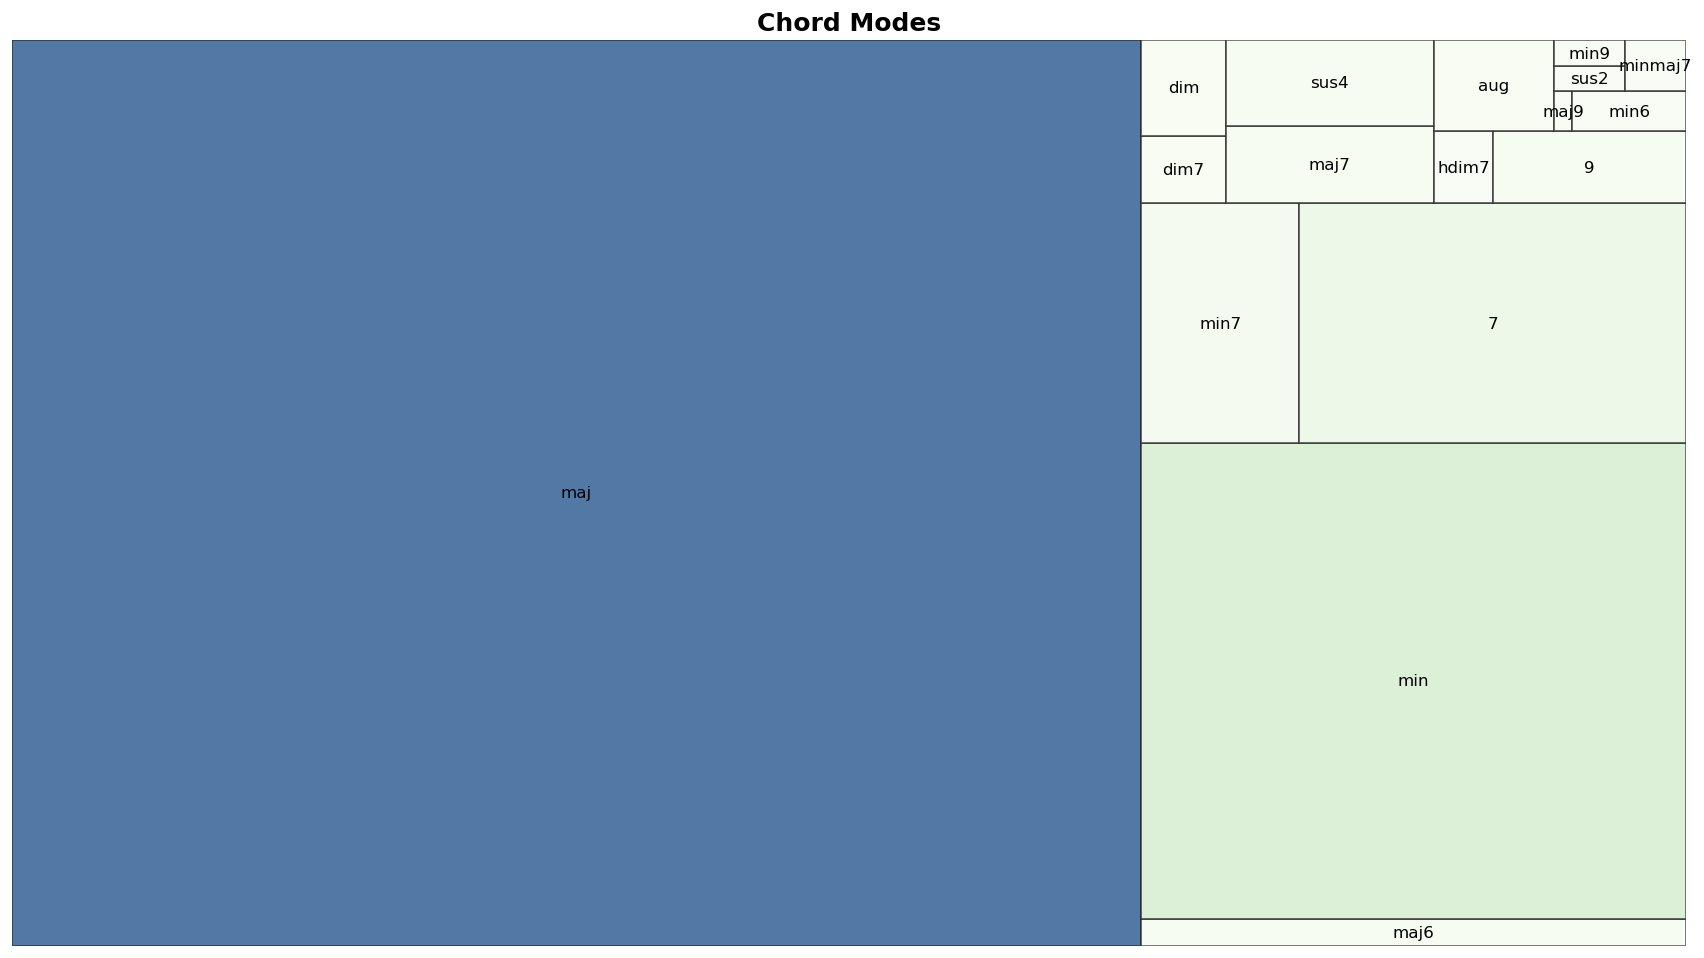

In [14]:
import squarify
import matplotlib

my_values = [value for value in Mode_Library.values()]
cmap = plt.cm.GnBu
mini=min(my_values)
maxi=max(my_values)

norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in my_values]
 
# Change color
plt.figure(num=None, figsize=(18, 10), dpi=120, facecolor='w', edgecolor='k')
squarify.plot(label=[key for key in Mode_Library.keys()], sizes=my_values, alpha=0.7, color=colors, bar_kwargs=dict(linewidth=1, edgecolor="#222222"))
plt.title("Chord Modes",fontsize=15,fontweight="bold")
plt.axis('off')
plt.savefig('ChordModes.png')

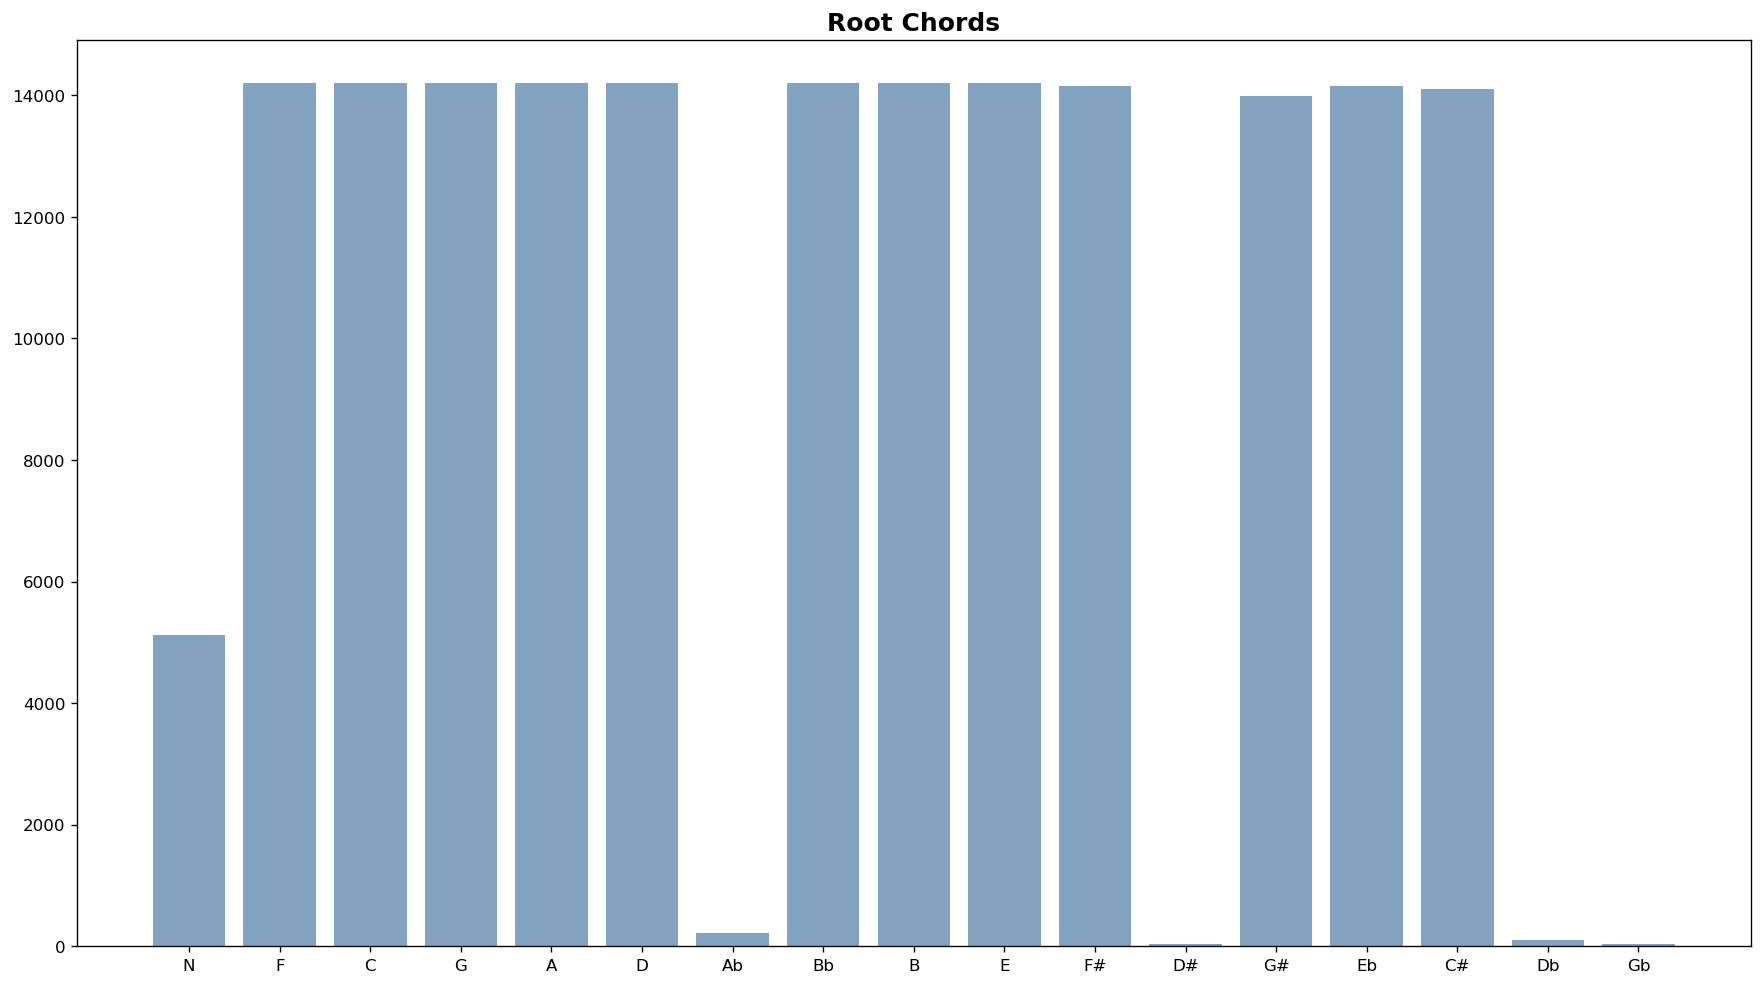

In [15]:
height = [Analytic_Library[key]['Total'] for key in Analytic_Library.keys()]

norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in my_values]
bars = [key for key in Analytic_Library.keys()]
y_pos = np.arange(len(bars))

plt.figure(num=None, figsize=(18, 10), dpi=120, facecolor='w', edgecolor='k')
plt.bar(y_pos, height, color=(0.2, 0.4, 0.6, 0.6))
plt.xticks(y_pos, bars)
plt.title("Root Chords",fontsize=15,fontweight="bold")
plt.savefig("RootChords.png")

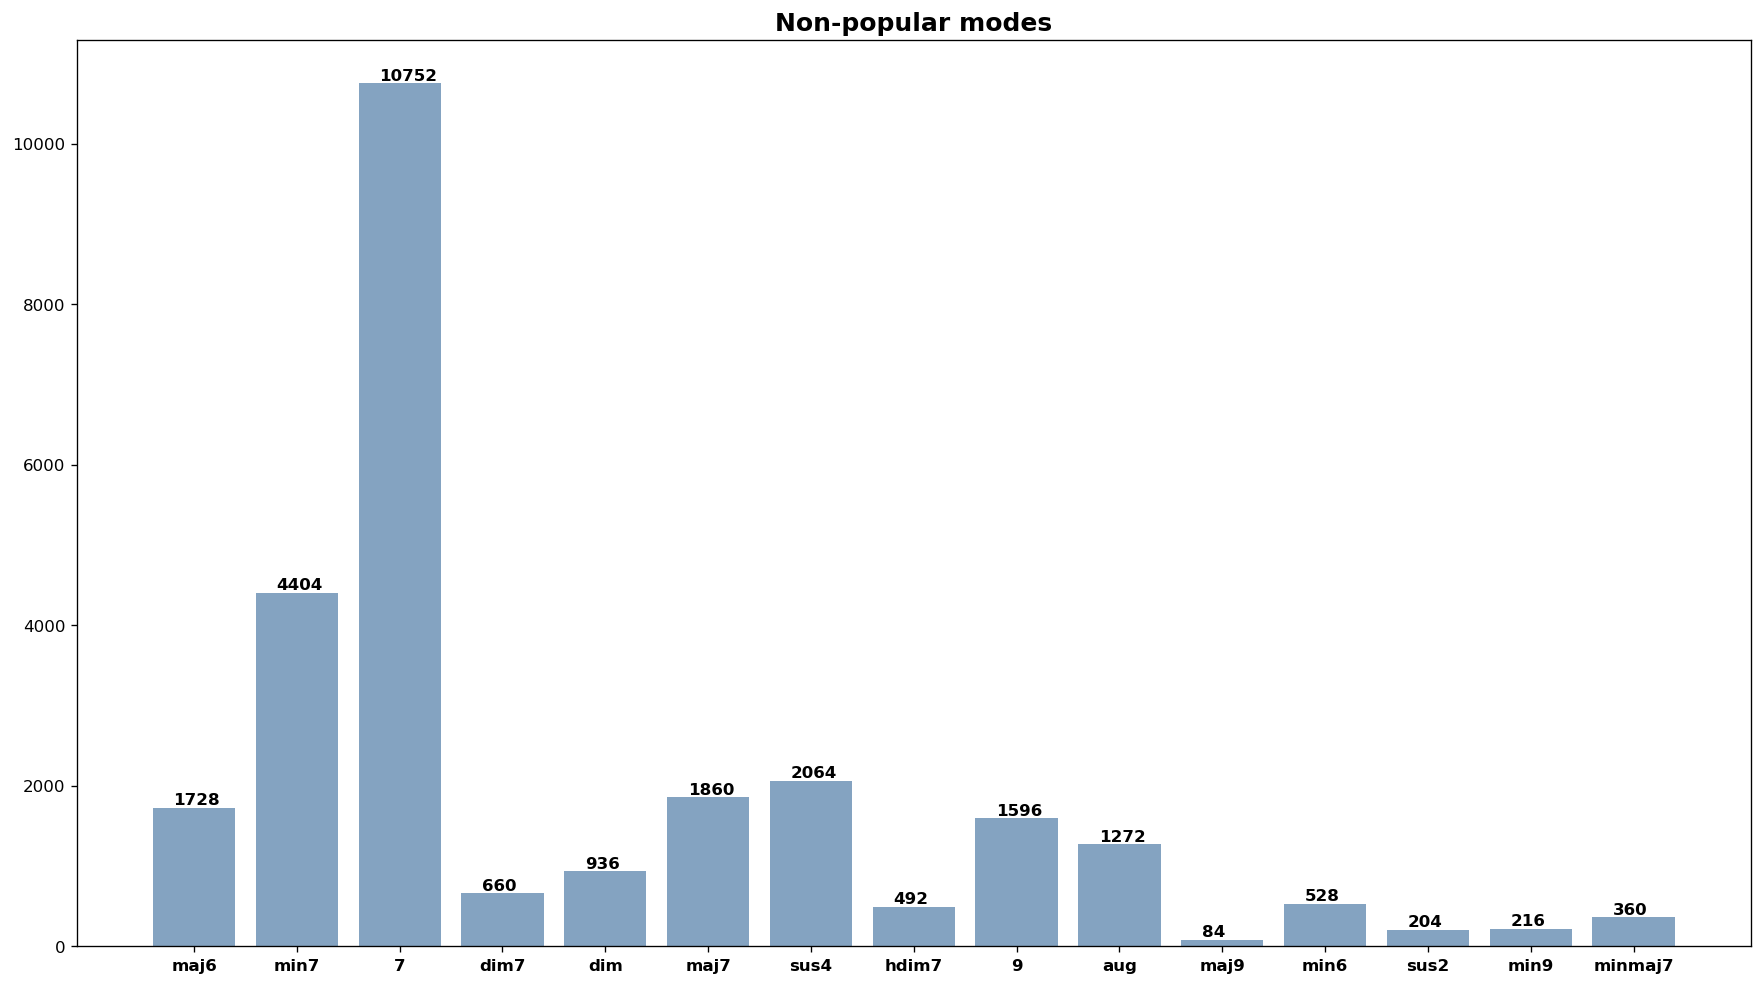

In [16]:
height = [value for value in Mode_Library.values()]

norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in my_values]
bars = [key for key in Mode_Library.keys()]
bars.pop(0)
height.pop(0)
bars.pop(1)
height.pop(1)
y_pos = np.arange(len(bars))

plt.figure(num=None, figsize=(18, 10), dpi=120, facecolor='w', edgecolor='k')
plt.bar(y_pos, height, color=(0.2, 0.4, 0.6, 0.6))
for i in range(len(height)):
    plt.text(x = i-0.2 , y = height[i]+40, s = height[i], size = 10, weight="bold")
plt.xticks(y_pos, bars, weight="bold")
plt.title("Non-popular modes",fontsize=15,fontweight="bold")
plt.savefig("ChordModesNumbers.png")

In [17]:
Total_Chords_Appearances, Extra_Chords_Appearances, Extra_Chords_Appearances / Total_Chords_Appearances

(175452, 4236, 0.0241433554476438)

In [18]:
print ('Major Chords: ', Mode_Library['maj'], '\nMinor Chords: ', Mode_Library['min'])

Major Chords:  118344 
Minor Chords:  29952


Major Chords = 4*Minor Chords -> 
1. We need to increment the number of minor chords
2. Or we can punish harder for the predictions on minor chords

## Dataset Annotations Transformation

In [45]:
ChordLib = {'C' : 0, 'C#': 1, 'Db' : 1, 'D' : 2, 'D#' : 3, 'Eb' : 3, 'E' : 4, 'Fb' : 4, 'F' : 5, 'F#' : 6, 'Gb' : 6, 'G' : 7, 'G#' : 8, 'Ab' : 8, 'A' : 9, 'A#' : 10, 'Bb' : 10, 'B' : 11, 'Cb' : 11, 'N' : 12, 'X' : 13}

<img src="images/intervals.png" width="400" />

<caption><center> <b>Figure 2</b>: Semitones to Intervals.</center></caption>

In [46]:
def interval_to_semitone(interval):
    if interval == '2':
        return 2
    elif interval == 'b2':
        return 1
    if interval == '3':
        return 4
    elif interval == 'b3':
        return 3
    if interval == '4':
        return 5
    if interval == '5':
        return 7
    elif interval == 'b5':
        return 6
    if interval == '6':
        return 9
    elif interval == 'b6':
        return 8
    if interval == '7':
        return 11
    elif interval == 'b7':
        return 10
    if interval == '9':
        return 14
    
    return 0

In [47]:
def Semitonize(interval, mode):
    if interval == '0':
        return 0
    
    if mode == 'Major':
        return interval_to_semitone(interval)
    elif mode == 'Minor':
        return interval_to_semitone(interval)
    elif mode == 'Dim':
        return interval_to_semitone(interval)
    elif mode == 'Aug':
        return interval_to_semitone(interval)
    else:
        return 0

In [48]:
Fourths = {'N' : 0, 'dim7' : 1, 'min7' : 2, 'maj7' : 3, 'maj6' : 4, 'X' : 5}
Triads = {'N' : 0, 'Major' : 1, 'Minor' : 2, 'Dim' : 3, 'Aug' : 4, 'Sus2' : 5, 'Sus4' : 6, 'X' : 7}

In [49]:
Semitones = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

In [50]:
def parse_chords(Chords, df):
    # silence
    df['Root'].append(ChordLib['N'])
    df['Bass'].append(ChordLib['N'])
    df['Unknown'].append(0)
    df['Triad'].append(Triads['N'])
    df['Fourth Note'].append(Fourths['N'])
    # for all chords in vocab
    for chord in Chords:
        if chord == 'N':
            continue
        
        root, quality, extra, bass = mir_eval.chord.split(chord)
        # initialize
        Mode = 'Major'
        fourth_note = ''
        fourth_note_mode = ''
        Unknown = False

        if quality == '7':
            #Dominant seventh
            Mode = 'Major'
            fourth_note = '7'
            fourth_note_mode = 'min'
        elif quality[:3] == 'min':
            Mode = 'Minor'
            if quality != 'min':
                if quality[3] == '7':
                    fourth_note = '7'
                    fourth_note_mode = 'min'
        elif quality[:3] == 'dim':
            Mode = 'Dim'
            if quality != 'dim':
                fourth_note = quality[3]
                fourth_note_mode = 'dim'
        elif quality[:3] == 'aug':
            # Root + Major third + Augmented fifth + Minor seventh
            Mode = 'Aug'
            if quality != 'aug':
                fourth_note = quality[3]
                fourth_note_mode = 'min'
        elif quality[:3] == 'maj':
            Mode = 'Major'
            if quality != 'maj':
                quality = quality[3:]
                fourth_note_mode = 'maj'
                fourth_note = quality[0]
        elif quality[:4] == 'sus2':
            Mode = 'Sus2'
        elif quality[:4] == 'sus4':
            Mode = 'Sus4'
        elif quality[:4] == 'sus7':
            Mode = 'Sus4'
            fourth_note = '7'
            fourth_note_mode = 'min'
        elif quality[:4] == 'sus9':
            Mode = 'Sus4'
            fourth_note = '7'
            fourth_note_mode = 'min'
            Unknown = True
        elif quality[:4] == 'hdim':
            #half diminished
            Mode ='Dim'
            fourth_note_mode = 'min'
            fourth_note = quality[4]
        elif quality == '9':
            #Dominant seventh
            Mode = 'Major'
            fourth_note = '7'
            fourth_note_mode = 'min'
        else:
            Unknown = True

        # find bass
        if bass == '1':
            bass = root
        else:
            bass = Semitones[(ChordLib[root] + interval_to_semitone(bass))%12]
        
        if not Unknown:
            #print(root, bass, Mode, fourth_note)
            df['Root'].append(ChordLib[root])
            df['Bass'].append(ChordLib[bass])
            df['Unknown'].append(0)
            df['Triad'].append(Triads[Mode])
            if (fourth_note != '7' and fourth_note != '6'):
                fourth_note = 'N'
                fourth_note_mode = ''
            df['Fourth Note'].append(Fourths[fourth_note_mode + fourth_note])
        else:
            df['Root'].append(ChordLib[root])
            df['Bass'].append(ChordLib[bass])
            df['Unknown'].append(1)
            df['Triad'].append(Triads[Mode])
            df['Fourth Note'].append(Fourths['X'])

In [51]:
df = pd.DataFrame(columns=('Root', 'Bass', 'Unknown', 'Triad', 'Fourth Note'))
representations = {'Root' : [], 'Bass' : [], 'Unknown' : [], 'Triad' : [], 'Fourth Note' : []}

In [52]:
parse_chords(Chords, representations)

**Convert the dictionary to dataframe**

In [53]:
df = pd.DataFrame(data=representations, index=Chords).rename_axis('Chord', axis = 1)
df.iloc[0:60]

Chord,Root,Bass,Unknown,Triad,Fourth Note
N,12,12,0,0,0
F:maj6,5,5,0,1,4
C,0,0,0,1,0
G,7,7,0,1,0
A:min,9,9,0,2,0
D:min7/4,2,7,0,2,2
F:maj/9,5,7,0,1,0
C/7,0,11,0,1,0
C/5,0,7,0,1,0
F,5,5,0,1,0


Now this is a dictionary for every chord<br>
I'm going to index every chord with its timestep just liek before, but instead of a one hot of size 407, we will have the above representation<br>

## Preprocessing

In [40]:
encoder = OneHotEncoder(categories='auto')
encoder.fit(np.array(list(range(0,14))).reshape(-1,1))

OneHotEncoder(categorical_features=None, categories='auto', drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=True)

In [41]:
encoder_triads = OneHotEncoder(categories='auto')
encoder_triads.fit(np.array(list(range(0,8))).reshape(-1,1))

OneHotEncoder(categorical_features=None, categories='auto', drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=True)

In [42]:
encoder_fourth = OneHotEncoder(categories='auto')
encoder_fourth.fit(np.array(list(range(0,6))).reshape(-1,1))

OneHotEncoder(categorical_features=None, categories='auto', drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=True)

In [54]:
### Annotations
Artist='The Beatles'
root_vec = {}
bass_vec = {}
quality_vec = {}
for album in Chordlab[Artist].keys():
    root_vec[album] = {}
    bass_vec[album] = {}
    quality_vec[album] = {}
    for track_no in Chordlab[Artist][album].keys():
        df_rows = Chordlab[Artist][album][track_no].itertuples()
        index = 0
        max_len = len(Chordlab[Artist][album][track_no])
        root = np.empty((14,))
        bass = np.empty((14,))
        quality = np.empty((15,)) # 1 + 8 + 6
        row = next(df_rows)
        for timestamp in Timestamps[Artist][album][track_no]:
            if ((index + 1) < max_len) & (timestamp >= row[2]):
                index += 1
                row = next(df_rows)
            root = np.column_stack((root, encoder.transform([[df.loc[row[3]]['Root']]]).toarray()[0]))
            bass = np.column_stack((bass, encoder.transform([[df.loc[row[3]]['Bass']]]).toarray()[0]))
            quality = np.column_stack((quality, np.append(np.append(df.loc[row[3]][2], encoder_triads.transform([[df.loc[row[3]][3]]]).toarray()[0]), encoder_fourth.transform([[df.loc[row[3]][4]]]).toarray()[0])))
        root_vec[album][track_no] = root
        bass_vec[album][track_no] = bass
        quality_vec[album][track_no] = quality
    print(album, ' completed')

09_-_Magical_Mystery_Tour  completed


KeyboardInterrupt: 

In [210]:
# Take care fo the one extra row in the beginning of the array
for album in root_vec.keys():
    for track_no in root_vec[album].keys():
        root_vec[album][track_no] = np.delete(root_vec[album][track_no], 0, 1)
        bass_vec[album][track_no] = np.delete(bass_vec[album][track_no], 0, 1)
        quality_vec[album][track_no] = np.delete(quality_vec[album][track_no], 0, 1)

In [22]:
### STORE
import pickle

with open('root_vec.pickle', 'wb') as handle:
    pickle.dump(root_vec, handle, protocol=pickle.HIGHEST_PROTOCOL)  

with open('bass_vec.pickle', 'wb') as handle:
    pickle.dump(bass_vec, handle, protocol=pickle.HIGHEST_PROTOCOL)     
    
with open('quality_vec.pickle', 'wb') as handle:
    pickle.dump(quality_vec, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [51]:
### LOAD
import pickle

with open('root_vec.pickle', 'rb') as handle:
    root_vec = pickle.load(handle)
    
with open('quality_vec.pickle', 'rb') as handle:
    quality_vec = pickle.load(handle)

### Constructing numpy arrays
chunk_size = slicing window (~22 secs)
<br>
input_features = nbins

In [31]:
# create test train splits sets
from sklearn.model_selection import train_test_split

df = pd.read_csv('ListFileNames.csv', sep='\t', header=None)
track_indexes = list(df.index)
X_ixtrain, X_ixtest = train_test_split(track_indexes, test_size=0.10, shuffle=True)
X_tracks_train = [(re.search('([0-9].)_-_',df.iloc[ix][0]).group(1), df.iloc[ix][1]) for ix in X_ixtrain]
X_tracks_test = [(re.search('([0-9].)_-_',df.iloc[ix][0]).group(1), df.iloc[ix][1]) for ix in X_ixtest]

In [22]:
chunk_size = 300

In [39]:
len(Timestamps['The Beatles']['09_-_Magical_Mystery_Tour']['09'])

1949

In [213]:
# train set
x_train = np.zeros((1,chunk_size,input_features)) #num of frequencies
y_train_root = np.zeros((1,chunk_size,14))
y_train_bass = np.zeros((1,chunk_size,14))
# test set
x_test = np.zeros((1,chunk_size,input_features)) #num of frequencies
y_test_root = np.zeros((1,chunk_size,14))
y_test_bass = np.zeros((1,chunk_size,14))

for album in root_vec.keys():
    for track_no in root_vec[album].keys():
        if len([(tr,alb) for tr, alb in X_tracks_test if album.find(alb) and tr == track_no]) > 0:
            continue
        timestep = 0
        # size of the current track
        chunks = len(Timestamps['The Beatles'][album][track_no])
        # track frequencies
        timeseries = Timeseries['The Beatles'][album][track_no]
        # track annotations
        annotations_root = root_vec[album][track_no].T
        annotations_bass = bass_vec[album][track_no].T
        # slice and stack train
        while timestep < chunks :
            if (chunks - timestep) > chunk_size:
                batch_x = np.resize(timeseries[timestep:timestep+chunk_size,:], (1, chunk_size, input_features)) #num of frequencies
                x_train = np.append(x_train, batch_x, axis = 0)
                batch_y = np.resize(annotations_root[timestep:timestep+chunk_size,:], (1, chunk_size, 14))
                y_train_root = np.append(y_train_root, batch_y, axis = 0)
                batch_y = np.resize(annotations_bass[timestep:timestep+chunk_size,:], (1, chunk_size, 14))
                y_train_bass = np.append(y_train_bass, batch_y, axis = 0)
            else:
                batch_x = timeseries[timestep:,:]
                batch_y_root = annotations_root[timestep:,:]
                batch_y_bass = annotations_bass[timestep:,:]
                for step in range (0, chunk_size + timestep - chunks):
                    batch_x = np.vstack((batch_x, np.zeros((1,input_features))))
                    batch_y_root = np.vstack((batch_y_root, encoder.transform([[df.loc['N']['Root']]]).toarray()[0]))
                    batch_y_bass = np.vstack((batch_y_bass, encoder.transform([[df.loc['N']['Root']]]).toarray()[0]))
                x_train = np.append(x_train, np.array([batch_x]), axis = 0)
                y_train_root = np.append(y_train_root, np.array([batch_y_root]), axis = 0)
                y_train_bass = np.append(y_train_bass, np.array([batch_y_bass]), axis = 0)
            timestep += chunk_size

        
for track_no,album in X_tracks_test:
    timestep = 0
    # size of the current track
    chunks = len(Timestamps['The Beatles'][album][track_no])
    # track frequencies
    timeseries = Timeseries['The Beatles'][album][track_no]
    # track annotations
    annotations_root = root_vec[album][track_no].T
    annotations_bass = bass_vec[album][track_no].T
    # slice and stack test
    while timestep < chunks :
        if (chunks - timestep) > chunk_size:
            batch_x = np.resize(timeseries[timestep:timestep+chunk_size,:], (1, chunk_size, input_features)) #num of frequencies
            x_test = np.append(x_test, batch_x, axis = 0)
            batch_y = np.resize(annotations_root[timestep:timestep+chunk_size,:], (1, chunk_size, 14))
            y_test_root = np.append(y_test_root, batch_y, axis = 0)
            batch_y = np.resize(annotations_bass[timestep:timestep+chunk_size,:], (1, chunk_size, 14))
            y_test_bass = np.append(y_test_bass, batch_y, axis = 0)
        else:
            batch_x = timeseries[timestep:,:]
            batch_y_root = annotations_root[timestep:,:]
            batch_y_bass = annotations_bass[timestep:,:]
            for step in range (0, chunk_size + timestep - chunks):
                batch_x = np.vstack((batch_x, np.zeros((1,input_features))))
                batch_y_root = np.vstack((batch_y_root, encoder.transform([[df.loc['N']['Root']]]).toarray()[0]))
                batch_y_bass = np.vstack((batch_y_bass, encoder.transform([[df.loc['N']['Root']]]).toarray()[0]))
            x_test = np.append(x_test, np.array([batch_x]), axis = 0)
            y_test_root = np.append(y_test_root, np.array([batch_y_root]), axis = 0)
            y_test_bass = np.append(y_test_bass, np.array([batch_y_bass]), axis = 0)
        # augment timesteps
        timestep += chunk_size

print (x_train.shape, y_train_root.shape, y_train_bass.shape, x_test.shape, y_test_root.shape, y_test_bass.shape)

(1024, 300, 192) (1024, 300, 14) (1024, 300, 14) (6, 300, 192) (6, 300, 14) (6, 300, 14)


**annotations quality**

In [215]:
y_train_quality = np.zeros((1,chunk_size,15))
y_test_quality = np.zeros((1,chunk_size,15))

for track_no,album in X_tracks_train:
    timestep = 0
    # size of the current track
    chunks = len(Timestamps['The Beatles'][album][track_no])
    # track frequencies
    timeseries = Timeseries['The Beatles'][album][track_no]
    # track annotations
    annotations_quality = quality_vec[album][track_no].T
    # slice and stack train data
    while timestep < chunks :
        if (chunks - timestep) > chunk_size:
            batch_y = np.resize(annotations_quality[timestep:timestep+chunk_size,:], (1, chunk_size, 15))
            y_train_quality = np.append(y_train_quality, batch_y, axis = 0)
        else:
            batch_y = annotations_quality[timestep:,:]
            for step in range (0, chunk_size + timestep - chunks):
                batch_y = np.vstack((batch_y, np.append(np.append(df.loc['N'][1], encoder_triads.transform([[df.loc['N'][2]]]).toarray()[0]), encoder_fourth.transform([[df.loc['N'][3]]]).toarray()[0])))
            y_train_quality = np.append(y_train_quality, np.array([batch_y]), axis = 0)
        timestep += chunk_size
            
for track_no,album in X_tracks_test:
    timestep = 0
    # size of the current track
    chunks = len(Timestamps['The Beatles'][album][track_no])
    # track frequencies
    timeseries = Timeseries['The Beatles'][album][track_no]
    # track annotations
    annotations_quality = quality_vec[album][track_no].T
    # slice and stack test
    while timestep < chunks :
        if (chunks - timestep) > chunk_size:
            batch_y = np.resize(annotations_quality[timestep:timestep+chunk_size,:], (1, chunk_size, 15))
            y_test_quality = np.append(y_test_quality, batch_y, axis = 0)
        else: 
            batch_y = annotations_quality[timestep:,:]
            for step in range (0, chunk_size + timestep - chunks):
                batch_y = np.vstack((batch_y, np.append(np.append(df.loc['N'][1], encoder_triads.transform([[df.loc['N'][2]]]).toarray()[0]), encoder_fourth.transform([[df.loc['N'][3]]]).toarray()[0])))
            y_test_quality = np.append(y_test_quality, np.array([batch_y]), axis = 0)
        timestep += chunk_size

print (y_train_quality.shape, y_test_quality.shape)

(1024, 300, 15) (6, 300, 15)


Delete the first row from every array because of the append, which left it all zeros.

In [217]:
x_train = np.delete(x_train,0,0)
x_test = np.delete(x_test,0,0)

y_train_root = np.delete(y_train_root,0,0)
y_test_root = np.delete(y_test_root,0,0)

y_train_bass = np.delete(y_train_bass,0,0)
y_test_bass = np.delete(y_test_bass,0,0)

y_train_quality = np.delete(y_train_quality,0,0)
y_test_quality = np.delete(y_test_quality,0,0)

### MIREX TEST

In [52]:
# validation set
x_mirex_test = {}
y_mirex_test_root = {}
y_mirex_test_bass = {}

for track_no,album in X_tracks_test:
    x_temp = np.zeros((1,chunk_size,input_features)) #num of frequencies
    y_temp_root = np.zeros((1,chunk_size,14))
    y_temp_bass = np.zeros((1,chunk_size,14))
    timestep = 0
    # size of the current track
    chunks = len(Timestamps['The Beatles'][album][track_no])
    # track frequencies
    timeseries = Timeseries['The Beatles'][album][track_no]
    # track annotations
    annotations_root = root_vec[album][track_no].T
    annotations_bass = bass_vec[album][track_no].T
    # test tracks
    while timestep < chunks :
        if (chunks - timestep) > chunk_size:
            batch_x = np.resize(timeseries[timestep:timestep+chunk_size,:], (1, chunk_size, input_features)) #num of frequencies
            x_temp = np.append(x_temp, batch_x, axis = 0)
            batch_y = np.resize(annotations_root[timestep:timestep+chunk_size,:], (1, chunk_size, 14))
            y_temp_root = np.append(y_temp_root, batch_y, axis = 0)
            batch_y = np.resize(annotations_bass[timestep:timestep+chunk_size,:], (1, chunk_size, 14))
            y_temp_bass = np.append(y_temp_bass, batch_y, axis = 0)
        else:
            batch_x = timeseries[timestep:,:]
            batch_y_root = annotations_root[timestep:,:]
            batch_y_bass = annotations_bass[timestep:,:]
            for step in range (0, chunk_size + timestep - chunks):
                batch_x = np.vstack((batch_x, np.zeros((1,input_features))))
                batch_y_root = np.vstack((batch_y_root, encoder.transform([[df.loc['N']['Root']]]).toarray()[0]))
                batch_y_bass = np.vstack((batch_y_bass, encoder.transform([[df.loc['N']['Root']]]).toarray()[0]))
            x_temp = np.append(x_temp, np.array([batch_x]), axis = 0)
            y_temp_root = np.append(y_temp_root, np.array([batch_y_root]), axis = 0)
            y_temp_bass = np.append(y_temp_bass, np.array([batch_y_bass]), axis = 0)
        # augment timesteps
        timestep += chunk_size
    x_temp = np.delete(x_temp,0,0)
    x_temp = np.reshape(x_temp, (x_temp.shape[0], x_temp.shape[1], x_temp.shape[2], 1))
    y_temp_root = np.delete(y_temp_root,0,0)
    y_temp_bass = np.delete(y_temp_bass,0,0)
    x_mirex_test[(track_no,album)] = x_temp
    y_mirex_test_root[(track_no,album)] = y_temp_root
    y_mirex_test_bass[(track_no,album)] = y_temp_bass

KeyError: '10CD1_-_The_Beatles'

In [50]:
y_mirex_test_quality = {}
for track_no,album in X_tracks_test:
    y_temp_quality = np.zeros((1,chunk_size,15))
    timestep = 0
    # size of the current track
    chunks = len(Timestamps['The Beatles'][album][track_no])
    # track frequencies
    timeseries = Timeseries['The Beatles'][album][track_no]
    # track annotations
    annotations_quality = quality_vec[album][track_no].T
    # test tracks
    while timestep < chunks :
        if (chunks - timestep) > chunk_size:
            batch_y = np.resize(annotations_quality[timestep:timestep+chunk_size,:], (1, chunk_size, 15))
            y_temp_quality = np.append(y_temp_quality, batch_y, axis = 0)
        else:
            batch_y = annotations_quality[timestep:,:]
            for step in range (0, chunk_size + timestep - chunks):
                batch_y = np.vstack((batch_y, np.append(np.append(df.loc['N'][1], encoder_triads.transform([[df.loc['N'][2]]]).toarray()[0]), encoder_fourth.transform([[df.loc['N'][3]]]).toarray()[0])))
            y_temp_quality = np.append(y_temp_quality, np.array([batch_y]), axis = 0)
        timestep += chunk_size
    y_temp_quality = np.delete(y_temp_quality,0,0)
    y_mirex_test_quality[(track_no,album)] = y_temp_quality

NameError: name 'root_vec' is not defined

In [289]:
y_mirex_test_triad = {}
y_mirex_test_fourth = {}
for track_no,album in X_tracks_test:
    _, y_mirex_test_triad[(track_no,album)], y_mirex_test_fourth[(track_no,album)] = np.dsplit(y_mirex_test_quality[(track_no,album)], [1,9,15])[0:3]

In [224]:
import pickle

with open('x_train_big.pickle', 'wb') as handle:
    pickle.dump(x_train, handle, protocol=pickle.HIGHEST_PROTOCOL)  
    
with open('x_test_big.pickle', 'wb') as handle:
    pickle.dump(x_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('x_val_big.pickle', 'wb') as handle:
    pickle.dump(x_val, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('y_train_root_big.pickle', 'wb') as handle:
    pickle.dump(y_train_root, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('y_val_root_big.pickle', 'wb') as handle:
    pickle.dump(y_val_root, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('y_test_root_big.pickle', 'wb') as handle:
    pickle.dump(y_test_root, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('y_train_bass_big.pickle', 'wb') as handle:
    pickle.dump(y_train_bass, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('y_val_bass_big.pickle', 'wb') as handle:
    pickle.dump(y_val_bass, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('y_test_bass_big.pickle', 'wb') as handle:
    pickle.dump(y_test_bass, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('y_train_quality_big.pickle', 'wb') as handle:
    pickle.dump(y_train_quality, handle, protocol=pickle.HIGHEST_PROTOCOL) 

with open('y_test_quality_big.pickle', 'wb') as handle:
    pickle.dump(y_test_quality, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('y_val_quality_big.pickle', 'wb') as handle:
    pickle.dump(y_val_quality, handle, protocol=pickle.HIGHEST_PROTOCOL)  
    
with open('y_train_bass_big.pickle', 'wb') as handle:
    pickle.dump(y_train_bass, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('y_mirex_test_bass_big.pickle', 'wb') as handle:
    pickle.dump(y_mirex_test_bass, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('y_test_bass_big.pickle', 'wb') as handle:
    pickle.dump(y_test_bass, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [55]:
import pickle

with open('x_train_big.pickle', 'rb') as handle:
    x_train = pickle.load(handle)  
    
with open('x_val_big.pickle', 'rb') as handle:
    x_test = pickle.load(handle)
    
with open('y_train_root_big.pickle', 'rb') as handle:
    y_train_root = pickle.load(handle)
    
with open('y_val_root_big.pickle', 'rb') as handle:
    y_test_root = pickle.load(handle)
    
with open('y_train_quality_big.pickle', 'rb') as handle:
    y_train_quality = pickle.load(handle)

with open('y_test_quality_big.pickle', 'rb') as handle:
    y_test_quality = pickle.load(handle)
    
with open('y_val_quality_big.pickle', 'rb') as handle:
    y_test_quality = pickle.load(handle)  
    
with open('y_train_bass_big.pickle', 'rb') as handle:
    y_train_bass = pickle.load(handle)
    
with open('y_val_bass_big.pickle', 'rb') as handle:
    y_test_bass = pickle.load(handle)

In [56]:
y_test_unknown, y_test_triad, y_test_fourth = np.dsplit(y_test_quality, [1,9,15])[0:3]
y_train_unknown, y_train_triad, y_train_fourth = np.dsplit(y_train_quality, [1,9,15])[0:3]

## Imbalanced Classification
In this project we built our own dataset from beatles, so raw data are accompanied by ireguralizations such as imbalanced classes. We come across X major chords, but only X/3 minor chords. Image for the rest of the classes. So in order to have a balanced classification, we need our model to balance all the classes, by <b> paying attention more to <u>certain samples</u> and not certain classes, beause our classification is <u>multi label</u> and <u>not multi class</u> !!</b><br>

In [26]:
from sklearn.utils import class_weight

InverseLib = {0 : 'C', 1 : 'C#', 2 : 'D', 3 : 'Eb', 4 : 'E', 5 : 'F', 6 : 'F#', 7 : 'G', 8 : 'G#', 9 : 'A', 10 : 'Bb', 11 : 'B', 12 : 'N'}
InverseLibTriad = {0 : 'N', 1 : 'Major', 2 : 'Minor', 3 : 'Dim', 4 : 'Aug', 5 : 'Sus2', 6 : 'Sus4', 7 : 'X'}
InverseLibFourth = {0 : 'N', 1 : 'dim7', 2 : 'min7', 3 : 'maj7', 4 : 'maj6', 5 : 'X'}

#### Unique root chord appearances

In [122]:
Artist='The Beatles'
Chord_Appearances = {'A' : 0, 'A#' : 0, 'Bb' : 0, 'B' : 0, 'C' : 0, 'C#' : 0, 'Db' : 0, 'D' : 0, 'D#' : 0, 'Eb' : 0,
                    'E' : 0, 'F' : 0, 'F#' : 0, 'Gb' : 0, 'G' : 0, 'G#' : 0, 'Ab' : 0, 'N' : 0,}
for album in Chordlab[Artist].keys():
    for track_no in Chordlab[Artist][album].keys():
        for index, starts, ends, chord in Chordlab[Artist][album][track_no].itertuples():
            if chord.find(':') != -1:
                chord, _ = chord.split(':')
            if chord.find('/') != -1:
                chord, _ = chord.split('/')
            Chord_Appearances[chord] += 1
            
for root in Chord_Appearances.keys():
    print(root, ':\t', Chord_Appearances[root])

A :	 6899
A# :	 0
Bb :	 5187
B :	 6325
C :	 6296
C# :	 5058
Db :	 98
D :	 6641
D# :	 43
Eb :	 4654
E :	 6534
F :	 6100
F# :	 5572
Gb :	 40
G :	 6778
G# :	 4532
Ab :	 213
N :	 2135


In [28]:
Triads_Appearances = {'N' : 0, 'Major' : 0, 'Minor' : 0, 'Dim' : 0, 'Aug' : 0, 'Sus2' : 0, 'Sus4' : 0, 'X' : 0}
Fourths_Appearances = {'N' : 0, 'dim7' : 0, 'min7' : 0, 'maj7' : 0, 'maj6' : 0, 'X' : 0}
Root_Appearances = {'C' : 0, 'C#' : 0,'D' : 0, 'Eb' : 0, 'E' : 0, 'F' : 0, 'F#' : 0, 'G' : 0, 'G#' : 0, 'A' : 0, 'Bb' : 0, 'B' : 0, 'N' : 0}

### Balance Root

In [252]:
for chunk in y_train_root:
    for label in chunk:
        Root_Appearances[InverseLib[encoder.inverse_transform([label]).reshape(1,)[0]]] += 1
              
print (Root_Appearances)

{'C': 271254, 'C#': 271254, 'D': 271254, 'Eb': 271254, 'E': 271254, 'F': 271254, 'F#': 271254, 'G': 271254, 'G#': 271254, 'A': 271254, 'Bb': 271254, 'B': 271254, 'N': 427752}


In [186]:
# convert one hot to integers
y_ints = [y.argmax() for chunk in y_train_root for y in chunk]
# compute class weights
root_class_weights = class_weight.compute_class_weight('balanced', np.unique(y_ints, axis=0), y_ints)

### Balance Triads

In [253]:
for chunk in y_train_triad:
    for label in chunk:
        Triads_Appearances[InverseLibTriad[encoder_triads.inverse_transform([label]).reshape(1,)[0]]] += 1
        
print (Triads_Appearances)

{'N': 427752, 'Major': 2552400, 'Minor': 626460, 'Dim': 30588, 'Aug': 22116, 'Sus2': 2616, 'Sus4': 20868, 'X': 0}


In [254]:
# convert one hot to integers
y_ints = [y.argmax() for chunk in y_train_triad for y in chunk]
# compute class weights
triad_class_weights = class_weight.compute_class_weight('balanced', np.unique(y_ints, axis=0), y_ints)

### Balance Fourths

In [36]:
for chunk in y_train_fourth:
    for label in chunk:
        Fourths_Appearances[InverseLibFourth[encoder_fourth.inverse_transform([label]).reshape(1,)[0]]] += 1
        
print (Fourths_Appearances)

{'N': 6483384, 'dim7': 21288, 'min7': 696672, 'maj7': 55848, 'maj6': 69792, 'X': 38616}


In [37]:
# convert one hot to integers
y_ints = [y.argmax() for chunk in y_train_fourth for y in chunk]
# compute class weights
fourth_class_weights = class_weight.compute_class_weight('balanced', np.unique(y_ints, axis=0), y_ints)

### Balance Unknown

In [191]:
# no need for balancing here
unknown_class_weights = {0:1,1:1}

### Build Sample Weights

In [257]:
triad_sample_weights = np.ones((x_train.shape[0], x_train.shape[1]))

y_ints = [y.argmax() for chunk in y_train_triad for y in chunk]
i = 0
j = 0
for yi in y_ints:
    triad_sample_weights[i][j] = min(triad_class_weights[yi], 2)
    j += 1
    if j == chunk_size:
        i += 1
        j = 0

In [50]:
fourth_sample_weights = np.ones((x_train.shape[0], x_train.shape[1]))

y_ints = [y.argmax() for chunk in y_train_fourth for y in chunk]
i = 0
j = 0
for yi in y_ints:
    if fourth_class_weights[yi] <= 1:
        w = 1
    else:
        w = np.log(fourth_class_weights[yi])
    fourth_sample_weights[i][j] = min(w, 5)
    j += 1
    if j == chunk_size:
        i += 1
        j = 0

In [42]:
with open('fourth_sample_weights.pickle', 'wb') as handle:
    pickle.dump(fourth_sample_weights, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
root_sample_weights = np.ones((x_train.shape[0], x_train.shape[1]))
bass_sample_weights = np.ones((x_train.shape[0], x_train.shape[1]))
unknown_sample_weights = np.ones((x_train.shape[0], x_train.shape[1]))

In [28]:
fourth_sample_weights = np.ones((x_train.shape[0], x_train.shape[1]))

In [29]:
triad_sample_weights = np.ones((x_train.shape[0], x_train.shape[1]))

## Neural Network

In [57]:
from tensorflow.keras.layers import Input, TimeDistributed, Embedding, LSTM, Bidirectional, Dropout, Dense, GRU, concatenate, Conv1D, Conv2D, Flatten,MaxPooling1D, MaxPooling2D, LocallyConnected1D, Activation, GaussianNoise, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal, RandomUniform

#### BLSTM_2Layer

In [58]:
def BLSTM_2Layer(chords_num, input_features, timesteps, batch_size):
    
    main_input = Input(shape=(timesteps,input_features), name='main_input')
    
    #BLSTM
    x = Bidirectional(LSTM(units = 96, 
                           batch_input_shape = (batch_size, timesteps, input_features),
                           return_sequences = True))(main_input)
    x = Dropout(0.4)(x)
    #BLSTM on the concatanted output
    x = Bidirectional(LSTM(units = 64,
                           return_sequences=True))(x)
    x = Dropout(0.4)(x)
    
    x = Dense(128)(x)
    linear = Activation('sigmoid')(x)
    #Dense for classification
    r = TimeDistributed(Dense(chords_num))(linear)
    root = Activation('softmax', name='root_output')(r)
    
    b = TimeDistributed(Dense(chords_num))(linear)
    bass = Activation('softmax', name='bass_output')(b)
    
    t = TimeDistributed(Dense(8))(linear)
    triad = Activation('softmax', name='triad_output')(t)
    
    f = TimeDistributed(Dense(6))(linear)
    fourth = Activation('softmax', name='fourth_output')(f)
    
    #model
    model = Model(inputs=[main_input], outputs=[root,bass,triad,fourth])

    return model

In [179]:
def RCNN_Net(chords_num, input_features, timesteps, batch_size):
    
    main_input = Input(shape=(timesteps,input_features,1), name='main_input')
    
    # Root part
    #Convolutional Stack 1
    c =  Conv2D(filters=16, 
            kernel_size=(3,3),
            padding='same')(main_input)
    c = Activation('relu')(c)
    c = BatchNormalization()(c)
    
    c =  Conv2D(filters=16, 
            kernel_size=(3,3),
            padding='same')(c)
    c = Activation('relu')(c)
    c = BatchNormalization()(c)
    
    c =  Conv2D(filters=16, 
            kernel_size=(3,3),
            padding='same')(c)
    c = Activation('relu')(c)
    c = BatchNormalization()(c)
    
    c = MaxPooling2D(pool_size=(1,3))(c)
    c = Dropout(0.25)(c)
    
    
    c =  Conv2D(filters=32, 
            kernel_size=(3,3),
            padding='same')(c)
    c = Activation('relu')(c)
    c = BatchNormalization()(c)
    
    c =  Conv2D(filters=32, 
            kernel_size=(3,3),
            padding='same')(c)
    c = Activation('relu')(c)
    c = BatchNormalization()(c)
    
    c =  Conv2D(filters=32, 
            kernel_size=(3,3),
            padding='same')(c)
    c = Activation('relu')(c)
    c = BatchNormalization()(c)
    
    c = MaxPooling2D(pool_size=(1,3))(c)
    c = Dropout(0.25)(c)
    
    
    c =  Conv2D(filters=64, 
            kernel_size=(3,3),
            padding='same')(c)
    c = Activation('relu')(c)
    c = BatchNormalization()(c)
    
    c =  Conv2D(filters=64, 
            kernel_size=(3,3),
            padding='same')(c)
    c = Activation('relu')(c)
    c = BatchNormalization()(c)
    
    
    c = MaxPooling2D(pool_size=(1,4))(c)
    c = Dropout(0.25)(c)
    
    
    xc = TimeDistributed(Flatten())(c)
    xc = BatchNormalization()(xc)
    
    xc = Dense(128)(xc)
    # Root Part
    root = Bidirectional(LSTM(units = 64,
                              return_sequences=True))(xc)
    
    linear = Dropout(0.4)(root)
    #Dense for classification
    r = TimeDistributed(Dense(chords_num))(linear)
    root = Activation('softmax', name='root_output')(r)
    
    b = TimeDistributed(Dense(chords_num))(linear)
    bass = Activation('softmax', name='bass_output')(b)
    
    t = TimeDistributed(Dense(8))(linear)
    triad = Activation('softmax', name='triad_output')(t)
    
    f = TimeDistributed(Dense(6))(linear)
    fourth = Activation('softmax', name='fourth_output')(f)
    
    #model
    model = Model(inputs=[main_input], outputs=[root,bass,triad,fourth])

    return model

In [238]:
def RCNN_Net(chords_num, input_features, timesteps, batch_size):
    
    main_input = Input(shape=(timesteps,input_features,1), name='main_input')
    
    # Root part
    #Convolutional Stack 1
    c =  Conv2D(filters=16, 
            kernel_size=(3,3),
            padding='same')(main_input)
    c = Activation('relu')(c)
    c = BatchNormalization()(c)
    
    c =  Conv2D(filters=16, 
            kernel_size=(3,3),
            padding='same')(c)
    c = Activation('relu')(c)
    c = BatchNormalization()(c)
    
    c =  Conv2D(filters=16, 
            kernel_size=(3,3),
            padding='same')(c)
    c = Activation('relu')(c)
    c = BatchNormalization()(c)
    
    c = MaxPooling2D(pool_size=(1,3))(c)
    c = Dropout(0.25)(c)
    
    
    c =  Conv2D(filters=32, 
            kernel_size=(3,3),
            padding='same')(c)
    c = Activation('relu')(c)
    c = BatchNormalization()(c)
    
    c =  Conv2D(filters=32, 
            kernel_size=(3,3),
            padding='same')(c)
    c = Activation('relu')(c)
    c = BatchNormalization()(c)
    
    c =  Conv2D(filters=32, 
            kernel_size=(3,3),
            padding='same')(c)
    c = Activation('relu')(c)
    c = BatchNormalization()(c)
    
    c = MaxPooling2D(pool_size=(1,3))(c)
    c = Dropout(0.25)(c)
    
    
    c =  Conv2D(filters=64, 
            kernel_size=(3,3),
            padding='same')(c)
    c = Activation('relu')(c)
    c = BatchNormalization()(c)
    
    c =  Conv2D(filters=64, 
            kernel_size=(3,3),
            padding='same')(c)
    c = Activation('relu')(c)
    c = BatchNormalization()(c)
    
    
    c = MaxPooling2D(pool_size=(1,4))(c)
    c = Dropout(0.25)(c)
    
    
    c =  Conv2D(filters=128, 
            kernel_size=(3,3),
            padding='same')(c)
    c = Activation('relu')(c)
    c = BatchNormalization()(c)
    
    c =  Conv2D(filters=128, 
            kernel_size=(3,3),
            padding='same')(c)
    c = Activation('relu')(c)
    c = BatchNormalization()(c)
    
    c = Dense(64)(c)
    
    xc = TimeDistributed(Flatten())(c)
    xc = BatchNormalization()(xc)

    # Root Part
    root = Bidirectional(LSTM(units = 128,
                              return_sequences=True))(xc)
    
    linear = Dropout(0.4)(root)
    #Dense for classification
    r = TimeDistributed(Dense(chords_num))(linear)
    root = Activation('softmax', name='root_output')(r)
    
    b = TimeDistributed(Dense(chords_num))(linear)
    bass = Activation('softmax', name='bass_output')(b)
    
    t = TimeDistributed(Dense(8))(linear)
    triad = Activation('softmax', name='triad_output')(t)
    
    f = TimeDistributed(Dense(6))(linear)
    fourth = Activation('softmax', name='fourth_output')(f)
    
    #model
    model = Model(inputs=[main_input], outputs=[root,bass,triad,fourth])

    return model

#### Summary

In [61]:
batch_size = 32
chunk_size = 300

In [62]:
model = BLSTM_2Layer(14, input_features, chunk_size, batch_size)

In [63]:
losses = {
    "root_output": "categorical_crossentropy",
    "bass_output": "categorical_crossentropy",
    "triad_output": "categorical_crossentropy",
    "fourth_output": "categorical_crossentropy",
}
lossWeights = {"root_output": 1.0, "bass_output": 1.0, "triad_output": 1.0, "fourth_output": 1.0}
opt = keras.optimizers.Adam(lr=0.001)

model.compile(optimizer=opt, loss=losses, loss_weights=lossWeights, metrics=["accuracy"])

In [64]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 300, 192)]   0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 300, 192)     221952      main_input[0][0]                 
__________________________________________________________________________________________________
dropout (Dropout)               (None, 300, 192)     0           bidirectional[0][0]              
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 300, 128)     131584      dropout[0][0]                    
______________________________________________________________________________________________

In [243]:
model.load_weights("model2_weights.h5")

In [244]:
# to use the hybrid model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], x_val.shape[2], 1))

In [86]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], x_val.shape[2]))

**Fit**

In [66]:
epochs = 5

# train
callback_history = model.fit(x_train, 
                             {"root_output": y_train_root, "bass_output": y_train_bass, "triad_output": y_train_triad,"fourth_output": y_train_fourth},
                             epochs=epochs, 
                             validation_data=(x_test, {"root_output": y_test_root, "bass_output": y_test_bass, "triad_output": y_test_triad,"fourth_output": y_test_fourth}), 
                             batch_size=batch_size,
                             verbose=1)

Train on 12276 samples, validate on 106 samples
Epoch 1/5
12276/12276 [==============================] - 82s 7ms/sample - loss: 5.8857 - root_output_loss: 2.3517 - bass_output_loss: 2.3479 - triad_output_loss: 0.7084 - fourth_output_loss: 0.4778 - root_output_accuracy: 0.1650 - bass_output_accuracy: 0.1638 - triad_output_accuracy: 0.7719 - fourth_output_accuracy: 0.8749 - val_loss: 6.1178 - val_root_output_loss: 2.3874 - val_bass_output_loss: 2.3713 - val_triad_output_loss: 0.7210 - val_fourth_output_loss: 0.5844 - val_root_output_accuracy: 0.0856 - val_bass_output_accuracy: 0.1325 - val_triad_output_accuracy: 0.7315 - val_fourth_output_accuracy: 0.8142
Epoch 2/5
12276/12276 [==============================] - 77s 6ms/sample - loss: 5.6324 - root_output_loss: 2.2567 - bass_output_loss: 2.2564 - triad_output_loss: 0.6674 - fourth_output_loss: 0.4519 - root_output_accuracy: 0.1947 - bass_output_accuracy: 0.1957 - triad_output_accuracy: 0.7794 - fourth_output_accuracy: 0.8802 - val_loss: 5

In [37]:
with open('rnn_callback_history_100epochs.pickle', 'wb') as handle:
    pickle.dump(callback_history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [296]:
# evaluate on test set
for track_no,album in X_tracks_test:
    loss, _, _, _, _, accuracy_root, accuracy_bass, accuracy_triad, accuracy_fourth = model.evaluate(x_mirex_test[(track_no,album)], [y_mirex_test_root[(track_no,album)], y_mirex_test_bass[(track_no,album)], y_mirex_test_triad[(track_no,album)], y_mirex_test_fourth[(track_no,album)]], batch_size=batch_size, verbose=0)
    print("Track ", album , ' ', track_no)
    print("Accuracy root: \t\t% 3.2f %% \nAccuracy bass: \t\t% 3.2f %% \nAccuracy triad: \t% 3.2f %% \nAccuracy fourth: \t% 3.2f %% " %(100*accuracy_root, 100*accuracy_bass, 100*accuracy_triad, 100*accuracy_fourth))
    print("")

Track  05
Accuracy root: 		 38.83 % 
Accuracy bass: 		 21.83 % 
Accuracy triad: 	 85.50 % 
Accuracy fourth: 	 6.83 % 

Track  10
Accuracy root: 		 94.93 % 
Accuracy bass: 		 94.67 % 
Accuracy triad: 	 96.27 % 
Accuracy fourth: 	 96.53 % 

Track  02
Accuracy root: 		 64.67 % 
Accuracy bass: 		 57.56 % 
Accuracy triad: 	 79.48 % 
Accuracy fourth: 	 80.15 % 

Track  17
Accuracy root: 		 93.43 % 
Accuracy bass: 		 88.14 % 
Accuracy triad: 	 89.48 % 
Accuracy fourth: 	 83.33 % 

Track  12
Accuracy root: 		 92.27 % 
Accuracy bass: 		 91.33 % 
Accuracy triad: 	 93.53 % 
Accuracy fourth: 	 100.00 % 

Track  08
Accuracy root: 		 97.11 % 
Accuracy bass: 		 94.11 % 
Accuracy triad: 	 92.44 % 
Accuracy fourth: 	 88.78 % 

Track  14
Accuracy root: 		 93.85 % 
Accuracy bass: 		 94.70 % 
Accuracy triad: 	 96.52 % 
Accuracy fourth: 	 99.96 % 

Track  16
Accuracy root: 		 86.25 % 
Accuracy bass: 		 81.17 % 
Accuracy triad: 	 91.25 % 
Accuracy fourth: 	 87.75 % 

Track  06
Accuracy root: 		 89.52 % 
Acc

**Predictions -> Chords**

In [297]:
from sklearn.metrics import confusion_matrix
# predict root
cfm = {'fourths' : {}, 'triads' : {}, 'root' : {}, 'bass' : {}}
root_predictions = {}
bass_predictions = {}
triad_predictions = {}
fourth_predictions = {}
for track_no,album in X_tracks_test:
    root_predictions[(track_no,album)], bass_predictions[(track_no,album)], triad_predictions[(track_no,album)], fourth_predictions[(track_no,album)] = model.predict(x_mirex_test[(track_no,album)], batch_size=batch_size, use_multiprocessing=True)
    cfm['fourths'][(track_no,album)] = confusion_matrix(y_mirex_test_fourth[(track_no,album)], fourth_predictions[(track_no,album)])
    print('Track ', album, ' ', track_no, cfm['fourths'][(track_no,album)], '\n')

**Qualities:**<br>
Unknown | Major | Minor | Minor Seventh | Major Seventh | Augmented | Diminished | Ninth | Major Sixth

In [298]:
estimations_root = {}
estimations_triad = {}
estimations_fourth = {}
estimations_bass = {}

for track_no in root_vec[album_validate].keys():
    estimations_root[track_no] = []
    for batch_chords in root_predictions[track_no]:
        for chord in batch_chords:
            estimations_root[track_no].append(InverseLib[encoder.inverse_transform([chord]).reshape(1,)[0]])

    estimations_bass[track_no] = []            
    for batch_chords in bass_predictions[track_no]:
        for chord in batch_chords:
            estimations_bass[track_no].append(InverseLib[encoder.inverse_transform([chord]).reshape(1,)[0]])
    
    estimations_triad[track_no] = []  
    for quality in triad_predictions[track_no]:
        for s in quality:
            estimations_triad[track_no].append(InverseLibTriad[encoder_triads.inverse_transform([s]).reshape(1,)[0]])
    
    estimations_fourth[track_no] = []  
    for quality in fourth_predictions[track_no]:
        for s in quality:
            estimations_fourth[track_no].append(InverseLibFourth[encoder_fourth.inverse_transform([s]).reshape(1,)[0]])

### Plot Efficiency of model

In [40]:
with open('rnn_callback_history_100epochs.pickle', 'rb') as handle:
    callback_history.history = pickle.load(handle)

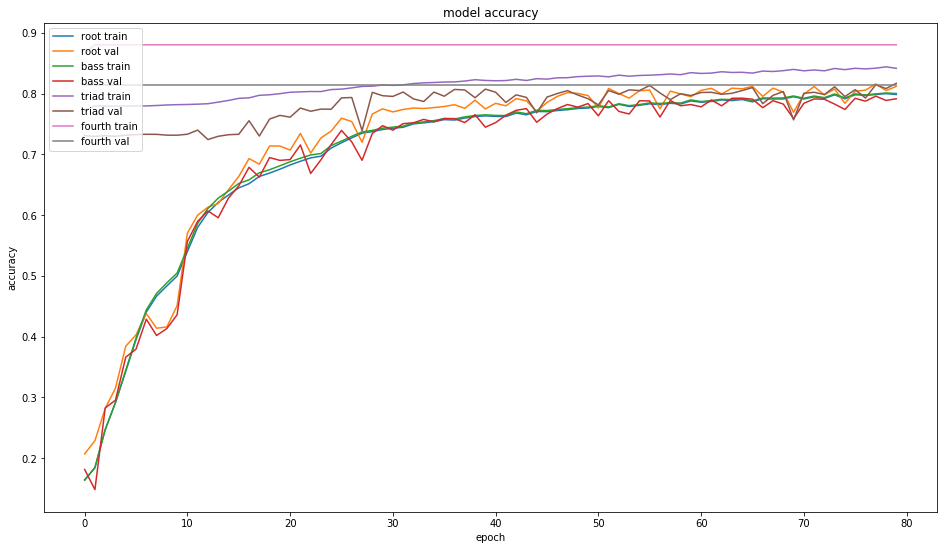

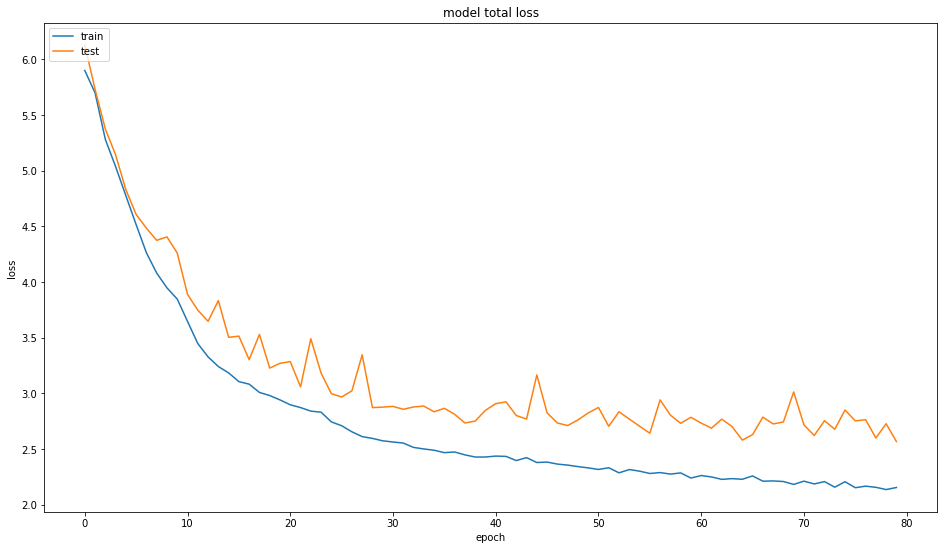

In [48]:
plt.figure(figsize=(16,9))
# summarize history for accuracy
plt.plot(callback_history.history['root_output_accuracy'])
plt.plot(callback_history.history['val_root_output_accuracy'])
plt.plot(callback_history.history['bass_output_accuracy'])
plt.plot(callback_history.history['val_bass_output_accuracy'])
plt.plot(callback_history.history['triad_output_accuracy'])
plt.plot(callback_history.history['val_triad_output_accuracy'])
plt.plot(callback_history.history['fourth_output_accuracy'])
plt.plot(callback_history.history['val_fourth_output_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['root train', 'root val', 'bass train', 'bass val', 'triad train', 'triad val', 'fourth train', 'fourth val'], loc='upper left')
plt.show()
plt.figure(figsize=(16,9))
# summarize history for loss
plt.plot(callback_history.history['loss'])
plt.plot(callback_history.history['val_loss'])
plt.title('model total loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Post Processing

Build function to transform **Root + Unknown + Triad + Fourth** -> **Full Chord**

Function to identify chord:
- feed the separate intervals -> return the full chord

In [251]:
# build a chordifier as a structure -> maybe a tree
def Chordify(root = 'N', bass = 'null', triad = 'null', fourth = 'null', unknown = 'null'):
    # silence
    if root == 'N': return root
    inverse = ''
    chord = root
    
    # cases
    if triad != 'Major' and triad != 'N' or (fourth != 'N' and fourth != 'X' and fourth != 'null'):
        chord += ':'
        
    if triad == 'Aug' and fourth != 'min7':
        chord += 'aug'
    elif triad == 'Aug' and fourth == 'min7':
        chord += 'aug7'
        
    if triad == 'Sus2':
        chord += 'sus2'
        
    if triad == 'Sus4':
        chord += 'sus4'
    
    if fourth == 'min7' and triad == 'Minor':
        chord += 'min7'
    elif fourth == 'min7' and triad == 'Dim':
        chord += 'hdim7'
    elif triad == 'Minor':
        chord += 'min'
    
    if triad == 'Dim' and fourth != 'min7':
        chord += 'dim'
    
    if fourth == 'min7' and triad == 'Major':
        chord += '7'
    
    if fourth == 'maj7':
        chord += 'maj7'
        
    if fourth == 'maj6':
        chord += 'maj6'
    
    # bass inversions
    if bass != 'null':
        if root != bass:
            semitones = (12 - ChordLib[root]) - (12 - ChordLib[bass])
            if semitones < 0:
                semitones += 12
            if semitones != 0:
                if semitones == 2:
                    inverse = '/2'
                elif semitones == 1:
                    inverse = '/b2'
                elif semitones == 3:
                    inverse = '/b3'
                elif semitones == 4:
                    inverse = '/3'
                elif semitones == 5:
                    inverse = '/4'
                elif semitones == 6:
                    inverse = '/b5'
                elif semitones == 7:
                    inverse = '/5'
                elif semitones == 9:
                    inverse = '/b7'
                elif semitones == 10:
                    inverse = '/7'
                elif semitones == 11:
                    inverse = '/#7'
            chord += inverse

    return chord

## Smoothing results

Heuristic solution to find the chord changes and smooth results

In [299]:
for track_no in root_vec[album_validate].keys():
    estimated_root_list = estimations_root[track_no]
    estimated_bass_list = estimations_bass[track_no]
    estimated_triad_list = estimations_triad[track_no]
    estimated_fourth_list = estimations_fourth[track_no]
    # initializations
    min_frames = 4
    current_chord_index = 0
    current_chord = estimated_root_list[0]
    current_mode = estimated_triad_list[0]
    current_bass = estimated_bass_list[0]
    current_fourth = estimated_fourth_list[0]
    previous_chord = estimated_root_list[0]
    previous_bass = estimated_bass_list[0]
    previous_mode = estimated_triad_list[0]
    previous_fourth = estimated_fourth_list[0]
    # 0 where chord is same, 1 where the chord changes
    chord_change = list(np.zeros((len(estimated_root_list),)))
    appearances = 1
    # scan root for lstm noise
    for i in range(1, len(estimated_root_list)):
        chord_root = estimated_root_list[i]
        if previous_chord != chord_root:
            previous_chord = chord_root
            if appearances <= min_frames:
                for j in range(i-appearances, i):
                    estimated_root_list[j] = previous_chord
            appearances = 1
        else:
            appearances += 1
    # re-scan root, and when root changes -> chord change = 1
    previous_chord = estimated_root_list[0]
    chord_change[0] = 1
    for i in range(1, len(estimated_root_list)):
        chord_root = estimated_root_list[i]
        if previous_chord != chord_root:
            chord_change[i] = 1
            previous_chord = chord_root
    # scan triads and fourths on chord change, to smooth lstm noise
    appearances_triad = 0
    appearances_fourth = 0
    appearances_bass = 0
    for i in range(0, len(estimated_root_list)):
        mode = estimated_triad_list[i]
        fourth = estimated_fourth_list[i]
        bass = estimated_bass_list[i]
        if chord_change[i]:
            if appearances_triad <= min_frames:
                for j in range(i-appearances_triad, i):
                    estimated_triad_list[j-1] = previous_mode
            if appearances_fourth <= min_frames:
                for j in range(i-appearances_fourth, i):
                    estimated_fourth_list[j-1] = previous_fourth
            if appearances_bass <= min_frames:
                for j in range(i-appearances_bass, i):
                    estimated_bass_list[j-1] = previous_bass
            appearances_triad = 0
            appearances_fourth = 0
            appearances_bass = 0
            previous_mode = mode
            previous_fourth = fourth
            previous_bass = bass
        # triad
        if current_mode != mode:
            if appearances_triad <= min_frames:
                for j in range(i-appearances_triad, i):
                    estimated_triad_list[j] = previous_mode
            else:
                previous_mode = current_mode
            current_mode = mode
            appearances_triad = 1
        else:
            appearances_triad += 1
        # fourth
        if current_fourth != fourth:
            if appearances_fourth <= min_frames:
                for j in range(i-appearances_fourth, i):
                    estimated_fourth_list[j] = previous_fourth
            else:
                previous_fourth = current_fourth
            current_fourth = fourth
            appearances_fourth = 1
        else:
            appearances_fourth += 1
        # bass
        if current_bass != bass:
            if appearances_bass <= min_frames:
                for j in range(i-appearances_bass, i):
                    estimated_bass_list[j] = previous_bass
            else:
                previous_bass = current_bass
            current_bass = bass
            appearances_bass = 1
        else:
            appearances_bass += 1
    #update
    estimations_root[track_no] = estimated_root_list
    estimations_bass[track_no] = estimated_bass_list
    estimations_triad[track_no] = estimated_triad_list
    estimations_fourth[track_no] = estimated_fourth_list 

In [301]:
track_no = '06'
for i in range(0,len(segments_true_chords[track_no])):
    print(i, estimations_root[track_no][i], estimations_bass[track_no][i], estimations_triad[track_no][i], estimations_fourth[track_no][i], " | ", segments_true_chords[track_no][i])

0 E E Minor N  |  N
1 E E Minor N  |  E:min(2)
2 E E Minor N  |  E:min(2)
3 E E Minor N  |  E:min(2)
4 E E Minor N  |  E:min(2)
5 E E Minor N  |  E:min(2)
6 E E Minor N  |  E:min(2)
7 E E Minor N  |  E:min(2)
8 E E Minor N  |  E:min(2)
9 E E Minor N  |  E:min(2)
10 E E Minor N  |  E:min(2)
11 E E Minor N  |  E:min(2)
12 E E Minor N  |  E:min(2)
13 E E Minor N  |  E:min(2)
14 E E Minor N  |  E:min(2)
15 E E Minor N  |  E:min(2)
16 E E Minor N  |  E:min(2)
17 E E Minor N  |  E:min(2)
18 E E Minor N  |  E:min(2)
19 E E Minor N  |  E:min(2)
20 E E Minor N  |  E:min(2)
21 E E Minor N  |  E:min(2)
22 E E Minor N  |  E:min(2)
23 E E Minor N  |  E:min(2)
24 E E Minor N  |  E:min(2)
25 E E Minor N  |  E:min(2)
26 E E Minor N  |  E:min(2)
27 E E Minor N  |  E:min(2)
28 E E Minor N  |  E:min(2)
29 E E Minor N  |  E:min(2)
30 E E Minor N  |  E:min(2)
31 E E Minor N  |  E:min(2)
32 E E Minor N  |  E:min(2)
33 E E Minor N  |  E:min(2)
34 E E Minor N  |  E:min(2)
35 E E Minor N  |  E:min(2)
36 E E Mi

737 A A Minor N  |  A:min
738 A A Minor N  |  A:min
739 A A Minor N  |  A:min
740 A A Minor N  |  A:min
741 A A Minor N  |  A:min
742 A A Minor N  |  A:min
743 A A Minor N  |  A:min
744 A A Minor N  |  A:min
745 A A Minor N  |  A:min
746 A A Minor N  |  A:min
747 A A Minor N  |  A:min
748 A A Minor N  |  A:min
749 A A Minor N  |  A:min
750 A A Minor N  |  A:min
751 A A Minor N  |  A:min
752 A A Minor N  |  A:min
753 A C Minor N  |  A:min
754 C C Major N  |  C
755 C C Major N  |  C
756 C C Major N  |  C
757 C C Major N  |  C
758 C C Major N  |  C
759 C C Major N  |  C
760 C C Major N  |  C
761 C C Major N  |  C
762 C C Major N  |  C
763 C C Major N  |  C
764 C C Major N  |  C
765 C C Major N  |  C
766 C C Major N  |  C
767 C C Major N  |  C
768 C C Major N  |  C
769 C C Major N  |  C
770 C C Major N  |  C
771 F F Major N  |  F
772 F F Major N  |  F
773 F F Major N  |  F
774 F F Major N  |  F
775 F F Major N  |  F
776 F F Major N  |  F
777 F F Major N  |  F
778 F F Major N  |  F
779 F F 

1470 C C Major N  |  C
1471 C C Major N  |  C
1472 C C Major N  |  C
1473 C C Major N  |  C
1474 C C Major N  |  C
1475 C C Major N  |  C
1476 C C Major N  |  C
1477 C C Major N  |  C
1478 C G Major N  |  C
1479 G G Major N  |  G
1480 G G Major N  |  G
1481 G G Major N  |  G
1482 G G Major N  |  G
1483 G G Major N  |  G
1484 G G Major N  |  G
1485 G G Major N  |  G
1486 G G Major N  |  G
1487 G G Major N  |  G
1488 G G Major N  |  G
1489 G G Major N  |  G
1490 C C Major N  |  C
1491 C C Major N  |  C
1492 C C Major N  |  C
1493 C C Major N  |  C
1494 C C Major N  |  C
1495 C C Major N  |  C
1496 C C Major N  |  C
1497 C C Major N  |  C
1498 C C Major N  |  C
1499 C C Major N  |  C
1500 D D Minor N  |  C
1501 D D Minor N  |  C
1502 D D Minor N  |  F:min
1503 D D Minor N  |  F:min
1504 D D Minor N  |  F:min
1505 D D Minor N  |  F:min
1506 D D Minor N  |  F:min
1507 D D Minor N  |  F:min
1508 D D Minor N  |  F:min
1509 D D Minor N  |  F:min
1510 D D Minor N  |  F:min
1511 D D Minor N  |  

#### Full Chord list

In [302]:
estimations_majmin = {}
estimations_inversion = {}
estimations_inversion_majmin = {}
estimations_fullchord = {}

for track_no in root_vec[album_validate].keys():
    estimated_root_list = estimations_root[track_no]
    estimated_bass_list = estimations_bass[track_no]
    estimated_triad_list = estimations_triad[track_no]
    estimated_fourth_list = estimations_fourth[track_no]
    estimations_majmin[track_no] = []
    estimations_fullchord[track_no] = []
    tr = 0
    for chord in estimated_root_list:
        triad = estimated_triad_list[tr]
        fourth = estimated_fourth_list[tr]
        estimations_majmin[track_no].append(Chordify(root=chord, triad=triad))
        estimations_fullchord[track_no].append(Chordify(root=chord, triad=triad, fourth=fourth))
        tr += 1

# MIREX Metrics

In [303]:
# library for mirex metrics
import mir_eval

In [304]:
# delete inversion tool for accuracy
def delete_inversion(chord):
    if chord.find('/') != -1:
        chord, _ = chord.split('/')
    return chord

### Create the reference labels

In [305]:
segments_true_chords = {}
for track_no in root_vec[album_validate].keys():
    times = Timestamps[Artist][album_validate][track_no]
    df_rows = Chordlab[Artist][album_validate][track_no].itertuples()
    index = 0
    max_len = len(Chordlab[Artist][album_validate][track_no])
    segments_true_chords[track_no] = []
    row = next(df_rows)
    for timestamp in times:
        if ((index + 1) < max_len) & (timestamp >= row[2]):
            index += 1
            row = next(df_rows)
        segments_true_chords[track_no].append(row[3])

### Root accuracy

In [306]:
mir_eval_root = {}
acc_mean = 0
root_acc = {}
for track_no in root_vec[album_validate].keys():
    reference_len = len(segments_true_chords[track_no])
    mir_eval_root[track_no] = mir_eval.chord.root(segments_true_chords[track_no], estimations_root[track_no][0:reference_len])
    root_acc[track_no] = np.sum(mir_eval_root[track_no])/len(segments_true_chords[track_no])
    acc_mean += root_acc[track_no]/17

print("Root Accuracy: % 3.3f %%" %(100*acc_mean))

Root Accuracy:  85.173 %


### Thirds accuracy

In [315]:
mir_eval_thirds = {}
acc_mean = 0
thirds_acc = {}
for track_no in root_vec[album_validate].keys():
    reference_len = len(segments_true_chords[track_no])
    mir_eval_thirds[track_no] = mir_eval.chord.thirds(segments_true_chords[track_no], estimations_majmin[track_no][0:reference_len])
    thirds_acc[track_no] = np.sum(mir_eval_thirds[track_no])/len(segments_true_chords[track_no])
    acc_mean += thirds_acc[track_no]/17

print("Third Accuracy: % 3.3f %%" %(100*acc_mean))

Third Accuracy:  83.075 %


### MajMin accuracy

In [316]:
mir_eval_majmin = {}
acc_mean = 0
majmin_acc = {}
for track_no in root_vec[album_validate].keys():
    reference_len = len(segments_true_chords[track_no])
    mir_eval_majmin[track_no] = mir_eval.chord.majmin(segments_true_chords[track_no], estimations_majmin[track_no][0:reference_len])
    majmin_acc[track_no] = np.sum(mir_eval_majmin[track_no])/len(segments_true_chords[track_no])
    acc_mean += majmin_acc[track_no]/17

print("MajMin Accuracy: % 3.3f %%" %(100*acc_mean))

MajMin Accuracy:  76.736 %


### MIREX accuracy
**(at least three correct notes between reference and estimated chord)**

In [318]:
mir_eval_mirex = {}
acc_mean = 0
mirex_acc = {}
for track_no in root_vec[album_validate].keys():
    reference_len = len(segments_true_chords[track_no])
    mir_eval_mirex[track_no] = mir_eval.chord.mirex(segments_true_chords[track_no], estimations_fullchord[track_no][0:reference_len])
    mirex_acc[track_no] = np.sum(mir_eval_mirex[track_no])/len(segments_true_chords[track_no])
    acc_mean += mirex_acc[track_no]/17

print("Mirex Accuracy: % 3.3f %%" %(100*acc_mean))

Mirex Accuracy:  83.256 %


### Sevenths accuracy

In [308]:
mir_eval_sevenths = {}
acc_mean = 0
sevenths_acc = {}
for track_no in root_vec[album_validate].keys():
    reference_len = len(segments_true_chords[track_no])
    mir_eval_sevenths[track_no] = mir_eval.chord.sevenths(segments_true_chords[track_no], estimations_fullchord[track_no][0:reference_len])
    sevenths_acc[track_no] = np.sum(mir_eval_sevenths[track_no])/len(segments_true_chords[track_no])
    acc_mean += sevenths_acc[track_no]/17

print("Sevenths Accuracy: % 3.3f %%" %(100*acc_mean))

Root Accuracy:  58.737 %


### CSR accuracy

In [309]:
#CSR
CSR = 0

#segments of audio data
segments = Timestamps[Artist][album_test_track][test_track_no]

#compute total time of correct estimations
step = 0
total_time_of_correct_estimation = 0
for time in segments:
    true_chord = segments_true_chords[step]
    estimated_chord = Chordify(root=estimated_chord_list[step], triad=estimated_triad_list[step])
    if (estimated_chord == delete_inversion(true_chord)):
        total_time_of_correct_estimation += 1
    step += 1

#total time of segments        
total_time_of_segments = Timestamps[Artist][album_test_track][test_track_no].shape[0]

#CSR
CSR = total_time_of_correct_estimation / total_time_of_segments
print ("Accuracy Achieved by MIREX metric CSR = % 3.3f %%" %(CSR*100))

KeyError: 0